#Download & Import Python Packages (in Google Colab)


> Import the sys module, which provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter






In [ ]:
import sys
print(sys.version)


3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]




> Install necessary development packages for Python and PortAudio using the apt-get package manager


> Install the PyAudio library using the pip package manager





In [ ]:
!apt-get install -y python3-dev portaudio19-dev
!pip install pyaudio

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-dev is already the newest version (3.10.6-1~22.04).
python3-dev set to manually installed.
The following additional packages will be installed:
  libportaudio2 libportaudiocpp0
Suggested packages:
  portaudio19-doc
The following NEW packages will be installed:
  libportaudio2 libportaudiocpp0 portaudio19-dev
0 upgraded, 3 newly installed, 0 to remove and 16 not upgraded.
Need to get 188 kB of archives.
After this operation, 927 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudio2 amd64 19.6.0-1.1 [65.3 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudiocpp0 amd64 19.6.0-1.1 [16.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 portaudio19-dev amd64 19.6.0-1.1 [106 kB]
Fetched 188 kB in 1s (203 kB/s)
Selecting previously unselected package libportaudio2:amd64.
(Reading database ...



> Install the ffmpeg-python library using the pip package manager




In [ ]:
!pip install ffmpeg-python



> Install the noisereduce library using the pip package manager




In [ ]:
!pip install noisereduce



> Import all the libraries that will be used in this Python programming project


In [ ]:
import pyaudio
import struct
import wave
from matplotlib import pyplot as plt
from matplotlib import animation
import random
import IPython
from scipy.io import wavfile
import soundfile as sf
import numpy as np
import io
import noisereduce as nr
from noisereduce.generate_noise import band_limited_noise
from google.colab import files
import statistics
import math
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
from scipy.io.wavfile import read as wav_read
import ffmpeg

#Functions

> Using the provided cell to capture audio and next convert it into a .wav file extension. This step confirms smooth progression for the following tasks




In [ ]:
AUDIO_HTML = """<script>var recordButton=document.createElement("BUTTON");recordButton.innerText="Press to start recording";document.body.appendChild(recordButton);var base64data=0,recorder,gumStream;navigator.mediaDevices.getUserMedia({audio:true}).then(function(stream){gumStream=stream;recorder=new MediaRecorder(stream);recorder.ondataavailable=function(e){var url=URL.createObjectURL(e.data);var preview=document.createElement('audio');preview.controls=true;preview.src=url;document.body.appendChild(preview);var reader=new FileReader();reader.readAsDataURL(e.data);reader.onloadend=function(){base64data=reader.result}};recorder.start()});function toggleRecording(){if(recorder&&"recording"===recorder.state){recorder.stop();gumStream.getAudioTracks()[0].stop();recordButton.innerText="Saving the recording... Please wait"}}function sleep(ms){return new Promise(resolve=>setTimeout(resolve,ms))}var data=new Promise(resolve=>{recordButton.onclick=()=>{toggleRecording();sleep(2e3).then(()=>resolve(base64data.toString()))}});</script>"""

def get_audio():
    display(HTML(AUDIO_HTML))
    data = eval_js("data")
    binary = b64decode(data.split(',')[1])

    process = (
        ffmpeg.input('pipe:0')
        .output('pipe:1', format='wav')
        .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
    )
    output, _ = process.communicate(input=binary)

    riff_chunk_size = len(output) - 8
    b = [(riff_chunk_size >> i) & 0xFF for i in range(0, 32, 8)]
    riff = output[:4] + bytes(b) + output[8:]

    sr, audio = wav_read(io.BytesIO(riff))
    return audio, sr




>Function to generate band-limited noise



In [ ]:
def noisy_audio_clip(min_freq, max_freq, samples, samplerate):
    noise = np.random.randn(samples)
    noise_fft = np.fft.fft(noise)
    f = np.fft.fftfreq(len(noise), 1/samplerate)
    noise_fft[(f < min_freq) | (f > max_freq)] = 0
    return np.fft.ifft(noise_fft).real

#Load Data



> Capture audio from the user using the interactive audio recorder function,
assigning the audio data to 'audio' and the sample rate to 'sr'




In [ ]:
audio, sr = get_audio()

> Plot the wave graph of the audio signal

> Plot the spectrum of the audio signal







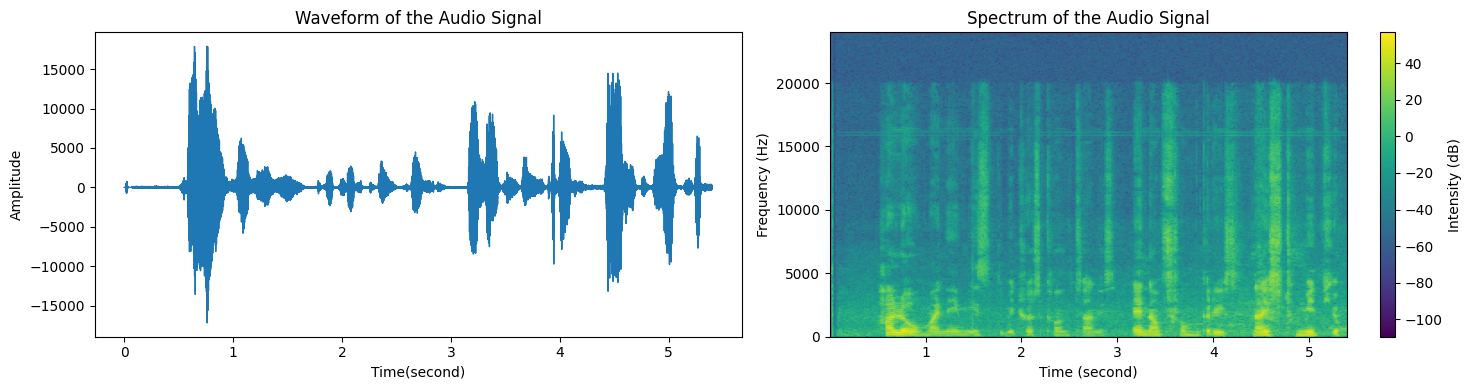

In [ ]:
plt.figure(figsize=(15, 4))
time = np.arange(0, len(audio)) / sr
plt.subplot(1, 2, 1)
plt.plot(time, audio, lw=1)
plt.title('Waveform of the Audio Signal')
plt.xlabel('Time(second)')
plt.ylabel('Amplitude')

plt.subplot(1, 2, 2)
specgram = plt.specgram(audio, Fs=sr, cmap='viridis', NFFT=1024)
plt.title('Spectrum of the Audio Signal')
plt.xlabel('Time (second)')
plt.ylabel('Frequency (Hz)')

cbar = plt.colorbar(specgram[3], ax=plt.gca())
cbar.set_label('Intensity (dB)')

plt.tight_layout()
plt.show()

#Add Noise

> Parameters for noise addition

> Generate band-limited noise





In [ ]:
noise_len = 2  # seconds
noise_factor = 0.2105
min_freq = 2000
max_freq = 12000

noise = noisy_audio_clip(min_freq=min_freq, max_freq=max_freq, samples=len(audio), samplerate=sr) * noise_factor
noise_clip = noise[:sr * noise_len]
noisy_audio_clip = audio + noise

>Print statistical measures of the noise data



In [ ]:
print("The mean of the noise is % s."%(statistics.mean(noise)))
print()
print("The variance of noise is % s."%(statistics.variance(noise)))
print()
print("The standard deviation of noise  is %s."%(math.sqrt(statistics.variance(noise))))
print()

The mean of the noise is -1.8697842323291166e-20.

The variance of noise is 0.004608882942650764.

The standard deviation of noise  is 0.06788875416923457.



> Mean and standard deviation of the noise

> Plot the Histogram of the noise

> Plot the probability density function (PDF) of the normal distribution of the noise









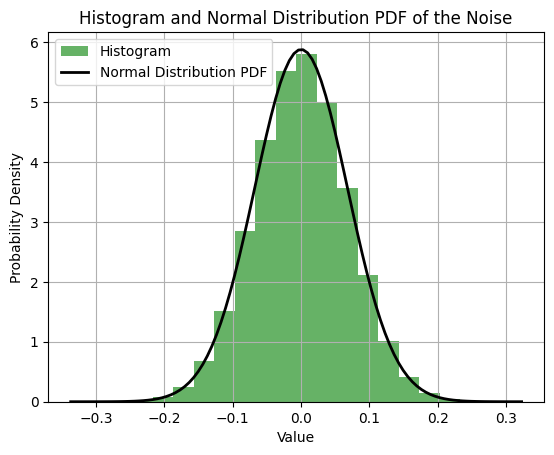

In [ ]:
mean_noise = np.mean(noise)
std_dev_noise = np.std(noise)

plt.hist(noise, bins=20, density=True, alpha=0.6, color='g', label='Histogram')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = (1/(std_dev_noise * np.sqrt(2 * np.pi))) * np.exp(-(x - mean_noise)**2 / (2 * std_dev_noise**2))
plt.plot(x, p, 'k', linewidth=2, label='Normal Distribution PDF')

plt.title('Histogram and Normal Distribution PDF of the Noise')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()

plt.grid()
plt.show()

> Plot the wave graph of the audio with added band-limited noise

> Plot the spectrum of the audio with added band-limited noise

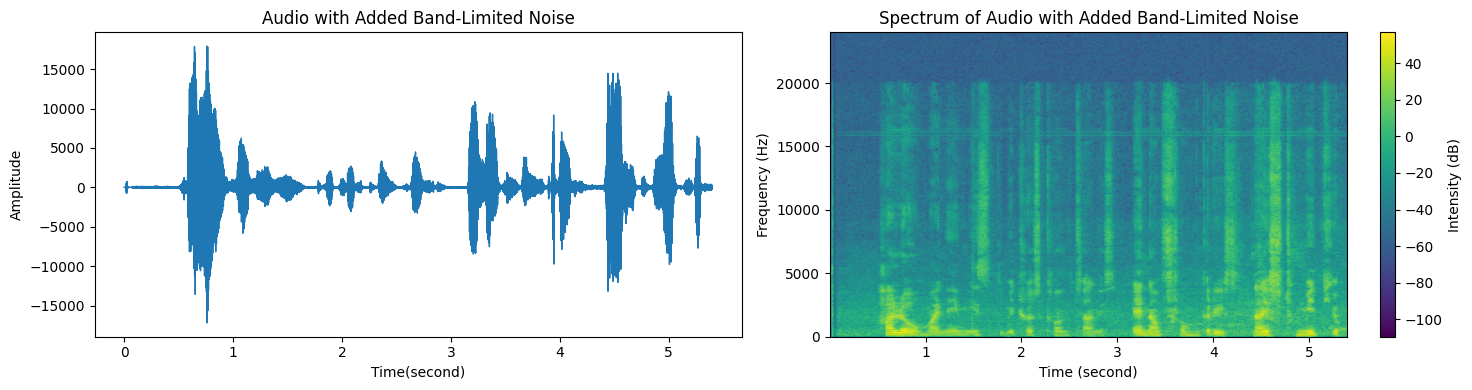

In [ ]:
plt.figure(figsize=(15, 4))
time = np.arange(0, len(noisy_audio_clip)) / sr
plt.subplot(1, 2, 1)
plt.plot(time, noisy_audio_clip, lw=1)
plt.title('Audio with Added Band-Limited Noise')
plt.xlabel('Time(second)')
plt.ylabel('Amplitude')

plt.subplot(1, 2, 2)
specgram = plt.specgram(noisy_audio_clip, Fs=sr, cmap='viridis', NFFT=1024)

cbar = plt.colorbar(specgram[3])
plt.title('Spectrum of Audio with Added Band-Limited Noise')
plt.xlabel('Time (second)')
plt.ylabel('Frequency (Hz)')
cbar.set_label('Intensity (dB)')

plt.tight_layout()
plt.show()

#Stationary Noise Reduction

> Apply noise reduction to the noisy_audio_clip using the reduce_noise function from the noisereduce library

> The stationary parameter is set to True, indicating a stationary noise reduction






In [ ]:
reduced_noise_stationary = nr.reduce_noise(y = noisy_audio_clip,sr=sr, n_std_thresh_stationary=1.638,stationary=True)

> Plot the wave graph of the stationary remove noise specific therhold

> Plot the spectrum of the stationary remove noise specific therhold



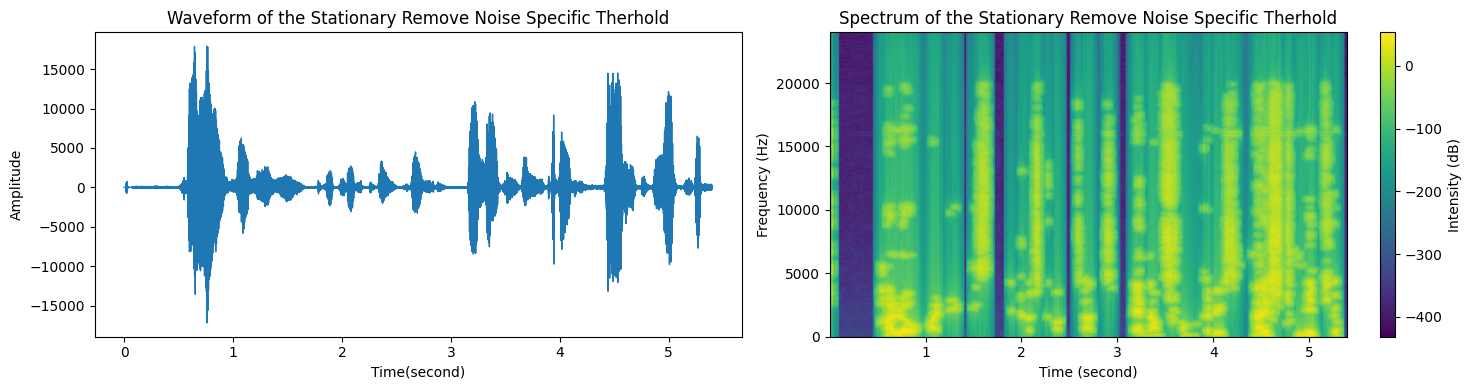

In [ ]:
plt.figure(figsize=(15, 4))
time = np.arange(0, len(reduced_noise_stationary)) / sr
plt.subplot(1, 2, 1)
plt.plot(time, audio, lw=1)
plt.title('Waveform of the Stationary Remove Noise Specific Therhold')
plt.xlabel('Time(second)')
plt.ylabel('Amplitude')

plt.subplot(1, 2, 2)
specgram = plt.specgram(reduced_noise_stationary, Fs=sr, cmap='viridis', NFFT=1024)
cbar = plt.colorbar(specgram[3])
plt.title('Spectrum of the Stationary Remove Noise Specific Therhold')
plt.xlabel('Time (second)')
plt.ylabel('Frequency (Hz)')
cbar.set_label('Intensity (dB)')

plt.tight_layout()
plt.show()

#Non-Stationary Noise Reduction

> Apply noise reduction to the noisy_audio_clip using the reduce_noise function from the noisereduce library

> The stationary parameter is set to True, indicating a non-stationary noise reduction




In [ ]:
reduced_noise_nonstationary = nr.reduce_noise(y = noisy_audio_clip, sr= sr, n_std_thresh_stationary=1.638,stationary=False)

> Plot the wave graph of the non-stationary remove noise specific therhold

> Plot the spectrum of the non-stationary remove noise specific therhold

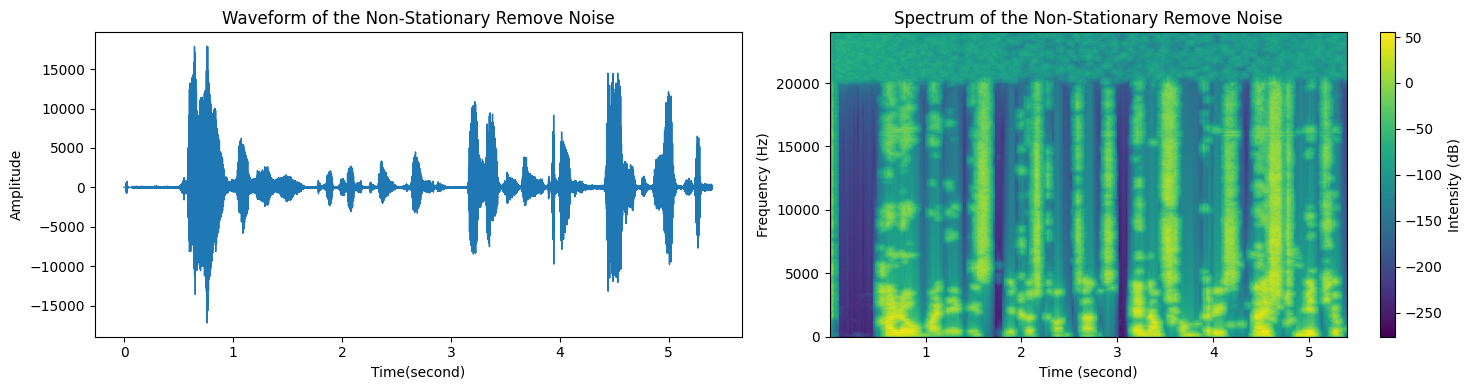

In [ ]:
plt.figure(figsize=(15, 4))
time = np.arange(0, len(reduced_noise_nonstationary)) / sr
plt.subplot(1, 2, 1)
plt.plot(time, audio, lw=1)
plt.title('Waveform of the Non-Stationary Remove Noise')
plt.xlabel('Time(second)')
plt.ylabel('Amplitude')

plt.subplot(1, 2, 2)
specgram = plt.specgram(reduced_noise_nonstationary, Fs=sr, cmap='viridis', NFFT=1024)

cbar = plt.colorbar(specgram[3])
plt.title('Spectrum of the Non-Stationary Remove Noise')
plt.xlabel('Time (second)')
plt.ylabel('Frequency (Hz)')
cbar.set_label('Intensity (dB)')

plt.tight_layout()
plt.show()